# Custom calculations
This document provides an introduction to Python custom calculation tags, as well as examples of the most common applications. You can skip ahead to the examples and change the variables to apply to your use case, or you can go through the full document to gain a deeper understanding, allowing you to solve use cases not covered by these examples.

This document does not attempt to give a full introduction the underlying Python SDK. To explore all possibilities, refer to https://python-sdk-core.trendminer.com.

**Do not attempt to run this notebook. Only use the code from the relevant sections.**

## Custom calculation basics

### Tag dependencies
When making a custom calculation tag, we need to manually enter the tags our calculation is dependent on. This will make sure that their indexes are up to date and we can use their most recent data. Unlike formula tags, custom calculation tags do not automatically infer tag dependencies from the code.

Forgetting this step might make our calculations stop or fail because the latest index data from the dependent tags is not available yet.

### Authentication
The custom calculation environment in TrendMiner contains the environment variable `ACCESS_TOKEN`, which is used to create a valid `client` object that can interact with the TrendMiner environment.

To get our custom calculations working in this external Jupyter notebook, we manually set a valid access token. We recommend replicating trying your custom calculations directly in TrendMiner, so there is no need for you tho replicate this step. You can simply ignore the snippet below.

*Authenticaiton mechanism: we are authenticating to a test environment using a client id and client secret (which is safely stored in our keychain so we do not have to put it in as plain text). An access token is returned which we can use to access the TrendMiner resources this particular client has been given access to.*

*We then overload the method that will return the correct URL from within the custom calculations environment to be the url of our server. This prevents us from adding the `url` parameter to the `from_token` method, which would prevent direct copying of the examples below into the custom calculations window in TrendMiner.*

In [1]:
# IGNORE ME. I AM NOT NEEDED IN THE CUSTOM CALCULATIONS ENVIRONMENT.
import os
import keycloak
import keyring

url = 'https://cs.trendminer.net'
client_id = 'wdanielsclient'

open_id = keycloak.KeycloakOpenID(
    server_url=f"{url}/auth/",
    realm_name="trendminer",
    client_id=client_id,
    client_secret_key=keyring.get_password(url, client_id),
)
    
token = open_id.token(
    grant_type="client_credentials",
)

os.environ.update({
    "ACCESS_TOKEN": token['access_token']
})

from trendminer.impl._util import DefaultUrlUtils
DefaultUrlUtils.get_default_url = lambda self, service_name: url

In the custom calculations editor, we can simply retrieve a valid token from the environment and use that to get a valid client. The following code will be present in every custom calculation tag:

In [2]:
import os
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
)

### Timezones

`TrendMinerClient` also takes a Python timezone string argument `tz`. Timezone-unaware timestamps entered by the user will be considered to be in this timezone. Also, when generating regular intervals such as days, weeks, months will be for this timezone. We recommend always setting the relevant timezone (i.e., the timezone of the plant).

If in doubt about your timezone identifier, you should be able to find it on https://en.wikipedia.org/wiki/List_of_tz_database_time_zones

In [3]:
import os
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"], 
    tz="Europe/Brussels",
)

### The index interval
This is the interval for which our calculation needs to output data. The index operation triggers our Python script, and the output is stored as indexed data in TrendMiner, where it is then used for visualizations and calculations. The custom calculation service will pass the start and end times of the interval requested by indexing as environmental variables.

*For this external notebook, let us set these variables manually.*

In [4]:
os.environ.update({
    "START_TIMESTAMP": "2024-01-11T00:05:12+00:00",
    "END_TIMESTAMP": "2024-02-01T00:00:00+00:00",
})

In our script, it will make sense to store these inputs into an interval instance. Our script so far thus becomes:

In [5]:
import os
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels"
)

index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

When we create a new custom calculation tag, **backward indexing** will first generate and index the historic data from the current time until the index horizon (an admin setting), in chunks the size of the index granularity (another admin setting). Assuming we have a default index granularity of 1 month configured, practically we will receive index intervals of one month, starting from current time moving backwards in time, and our script should calculate the custom tag data for those months. Calculation of historic data will stop before the index horizon if insufficient data is available in our dependent tags for calculation.

Once the historic index data for our custom calculation tag is present, the index will be kept up to date with the latest data via the **forward indexing** process. Forward indexing requests will typically happen on a schedule of 1h, and the requested index interval will range from the latest point in the index until the current time. Note that through this mechanism, it does not matter if we cannot provide data all the way up to the current time: the next forward indexing request will pick up where we left off.

If we put a monitor on our custom calculation tag, forward indexing will happen at a higher pace (approximately 2 minutes) so the monitor can be considered live. Thus, the index intervals fed to the calculation script will be even smaller.

A good custom calculation should be completely agnostic of the number and size of index intervals, and always generate the same data at the same timestamps.

### Output format
The result of our custom calculation script should be the generation of a csv file with two columns: the timestamps and the values. The name of the csv file is provided by a last environment variable.

*For this notebook, we again set this variable manually:*

In [6]:
os.environ.update({
    "OUTPUT_FILE": "my_tag.csv"
})

We now have all the components to create a dummy tag. Copying and pasting the code below results in a tag that always has the value 0. Do note that the actual datapoints in the resulting tag will depend on the index intervals received, which should not be the case for actual production tags.

The output expects the columns to be named `ts` and `value` respectively. We set the names of the index and the series itself to these values.

In [7]:
import os
import pandas as pd
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

ser = pd.Series(
    name="value",
    index=[
        index_interval.start,
        index_interval.end,
    ], 
    data=[0, 0],
)

ser.index.name="ts"

ser.to_csv(
    os.environ["OUTPUT_FILE"], 
)

## Retrieving data
Our custom calculation will need to retrieve data from TrendMiner to do someting useful. The three main inputs for custom calculation tags are:
- Time series data of other tags
- Value-based search results + calculations
- Aggregations on regular intervals (months, weeks, days, ...)

### Time series data
We can retrieve time series data by loading at tag by name, and then getting interpolated data for that tag for a given interval. Interpolated data is great because it allows easy calculations between tags. Do keep in mind that this data is obtained by interpolating the stored index data; requesting high data resolution data will not give access to any 'raw' data stored in the datasource.

Let's consider a simple example below where we add the values of two tags. Remember we should explicitly add both these tags as dependencies in the UI.

In [8]:
import os
import pandas as pd
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

tag1 = client.tag.get_by_name("[CS]BA:CONC.1")
tag2 = client.tag.get_by_name("[CS]BA:LEVEL.1")

ser1 = tag1.get_data(index_interval, resolution="1m")
ser2 = tag2.get_data(index_interval, resolution="1m")

ser = ser1+ser2

ser.name = "value"
ser.index.name = "ts"

ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

The example above is very straightforward because we can simply retrieve the timeseries data for the index interval. This stops being the case once our calculation needs to take into account a range of timeseries data. For example, if we would like to calculate the standard deviation of our tag over the last hour, we would need to retrieve the timeseries data one hour before our index interval.

We should always filter the resulting data to only include data inside the index interval. We need to make this filtering operation exclusive at the start time to **avoid duplicate timestamps at the boundaries of the index intervals**. Furthermore, it is also always prudent to remove any NaN values that might occur.

In [9]:
import os
import pandas as pd
from trendminer import TrendMinerClient

client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

window = client.time.timedelta("1h")

data_interval = client.time.interval(
    index_interval.start - window,
    index_interval.end,
)

tag = client.tag.get_by_name("[CS]BA:CONC.1")

ser = (
    tag.get_data(data_interval, resolution="1m")
    .rolling(window=window).std()
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

ser.name = "value"
ser.index.name = "ts"

ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Value based searches
Performing value-based searches and doing calculations on the results opens up a whole new world in terms of tag possibilities. 

The complexity in performing a search inside a custom calculation tag lies with figuring out what interval to search on depending on the index interval our script receives. Keep in mind, the central question to answer is: **what points need to be in my index interval, and how do I calculate these points?**

We need to look beyond the index interval to actually make sure we get complete search results. This means we need to make sure the start and end times of our search result are actually the start and end of the search condition, not of the search interval.

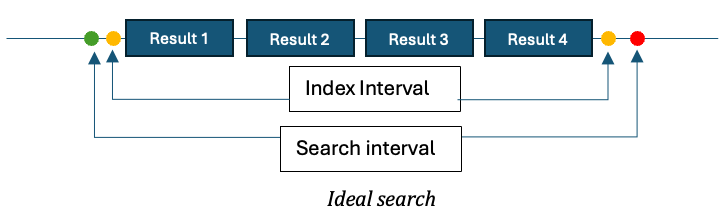

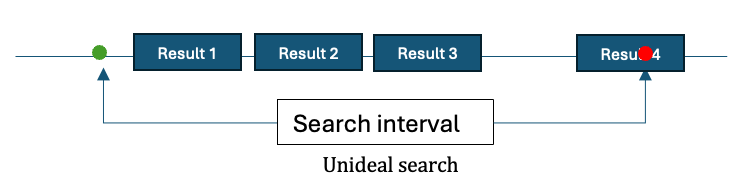

We can take care of this by searching beyond our index interval in such a way that we are guaranteed to find all the search results that at least partially fall in the index interval. In other words, we need to extend the index interval on both ends with the maximal possible duration of a search result. This is a parameter we need to set manually, depending on our use case. We can always take a larger maximal duration to be on the safe side, at the cost of some performance loss (as we unnecessarily search larger intervals).

Note that this approach can yield search results that are completely beyond the index interval, which we need to filter out. This will happen when filtering out points from our pandas Series that are not in the index interval, which is a step we should always add for robustness.

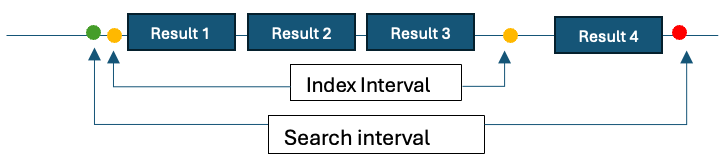

Another possible caveat to custom calculated tags is that the data of the target tags can be incomplete (i.e., the data is not yet in the historian), and the calculation will still give a result based on the (incomplete) available data. To avoid getting incorrect results from these partial calculations, we implement a check to see up to what timestamp all dependency tag have indexed data available.

Below is a simple example that gives the average temperature per batch as a block aggregate tag that returns to a default value of 0 in between batches. To get the average temperature, we can use the calculations on search results. The calculation results needs to be put at the start timestamps of the search results, the default value of 0 at the end timestamps of the search results. The tag created here is intended to be a **discrete** tag.

In [10]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.search import ValueBasedSearchOperators, SearchCalculationOptions

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

# Set a a safe maximal duration parameter. Here, a batch should never reach 2h duration.
maximal_duration = client.time.timedelta("2h")

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Load tags; add these as dependencies!
active = client.tag.get_by_name("[CS]BA:ACTIVE.1")
temperature = client.tag.get_by_name("[CS]BA:TEMP.1")

# Search definition
search = client.search.value(
    queries = [
        (active, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
    calculations = {
        "result": (temperature, SearchCalculationOptions.MEAN)
    }
)

# --- CODE EXECUTION ----

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Perform the search

results = search.get_results(search_interval)

# Remove open-ended result
if (len(results) > 0) and ((search_interval.end - results[-1].end) < client.resolution):
    results.pop(-1)

# Put the results in a Series
ser = pd.Series(
    name="value",
    index=[
        timestamp for result in results 
        for timestamp in (result.start, result.end)
    ],
    data=[
        value for result in results
        for value in (result["result"], 0)
    ],
)

ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

When we do not want to return to a default value in between search results, the code slightly simplifies as we do not need the end timestamps of the search results anymore. The only points we need to calculate are those of the search results that start within the index interval. Therefore, we do not need to look back to the period before the index interval anymore. However, we still have to look back one index resultion tick to make sure that the search result was not already ongoing before the index interval.

In case intensive operations happen on the search results after retrieving them, it is more efficient to filter out the search results we know are outside our index interval before the additional calculations.

In the example below, rather than doing calculations on search results, we actually pull time series from the search results for a custom operation (in this example, calculating the kurtosis). As this is a relatively expensive operation, we only do it for the results which actually start in the index interval.

In [11]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.search import ValueBasedSearchOperators

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

# Set a a safe maximal duration parameter
maximal_duration = client.time.timedelta("2h")

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Load tags
active = client.tag.get_by_name("[CS]BA:ACTIVE.1")
temperature = client.tag.get_by_name("[CS]BA:TEMP.1")

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Perform the search
search = client.search.value(
    queries = [
        (active, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
)

results = search.get_results(search_interval)

# Remove open-ended result
if (len(results) > 0) and ((search_interval.end - results[-1].end) < client.resolution):
    results.pop(-1)

# Process results
for result in results:

    # Only calculate when start is in the index interval
    if result.start in index_interval:
        profile = temperature.get_data(
            result,
            resolution="1m",
        )
        result["kurtosis"] = profile.kurt()

    # These NaN values will be filtered out of the Series object (dropna)
    else:
        result["kurtosis"] = pd.NA
    

# Put the results in a Series
ser = pd.Series(
    name="value",
    index=[
        timestamp for result in results 
        for timestamp in (result.start, result.end)
    ],
    data=[
        value for result in results
        for value in (result["kurtosis"], 0)
    ],
)

ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Regular intervals
A common use case is to implement block aggregates, counters and totalizers on regular intervals (days, weeks, ...). You can typically perform a value-based search on a time tag to get search results, processing of which would then work as detailed above. However, we can also get our intervals without explicitly performing a search, which is typically a cleaner and somewhat more performant solution. The resulting code looks very similar to that of getting search results, only we are generating our intervals from another function, and we use calculations on tags to get aggregate values.

When performing calculations on regular intervals, we need to take extra care to make sure our tags are actually completely indexed for the interval before performing the calculation.

In the example below, we calculate average temperatures on a weekly basis, starting Monday. As weeks happen back-to-back, there is no returning to a default value.

In [12]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",
)

# For a weekly calculation, the maximal duration is logically 7 days
freq = "W-MON"
maximal_duration = client.time.timedelta("7d")

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Load tags
temperature = client.tag.get_by_name("[CS]BA:TEMP.1")
tags = [temperature]

# Determine the last point up to which we can perform calculations (all tags indexed)
check_interval = client.time.interval(
    index_interval.start,
    client.time.now(),
)

last_timestamp = min([
    tag.get_plot_data(check_interval, n_intervals=1).index[-1]
    for tag in tags
])

# Get intervals
intervals = client.time.interval.range(
    freq=freq,
    start=index_interval.start,
    end=min([
        index_interval.end + maximal_duration,
        last_timestamp,
    ]),
    normalize=True,
)

# Calculate the weekly average temperature
temperature.calculate(
    intervals=intervals,
    operation=TagCalculationOptions.MEAN,
    key="temperature",
    inplace=True,
)

# Put the results in a Series
ser = pd.Series(
    name="value",
    index=[
        interval.start for interval in intervals 
    ],
    data=[
        interval["temperature"] for interval in intervals
    ],
)

ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

## Tag templates for regular intervals
These examples cover the operations that happen on regular intervals. Daily, weekly, monthly, and yearly intervals can be generated with the `client.time.interval.range` method with `normalize=True`. Note that this approach does not work for hourly intervals, for which you need to write a custom function (returning all full hours that overlap with the index interval). Alternatively, you could opt to perform a value-based search for a built-in hour tag (e.g, TM_hour_Europe_Brussels) being constant.

### Block aggregation
Below is the general template for a block aggregation on time-based intervals. This can be helpful for creating a tag for roll-up reporting or monitoring purposes.
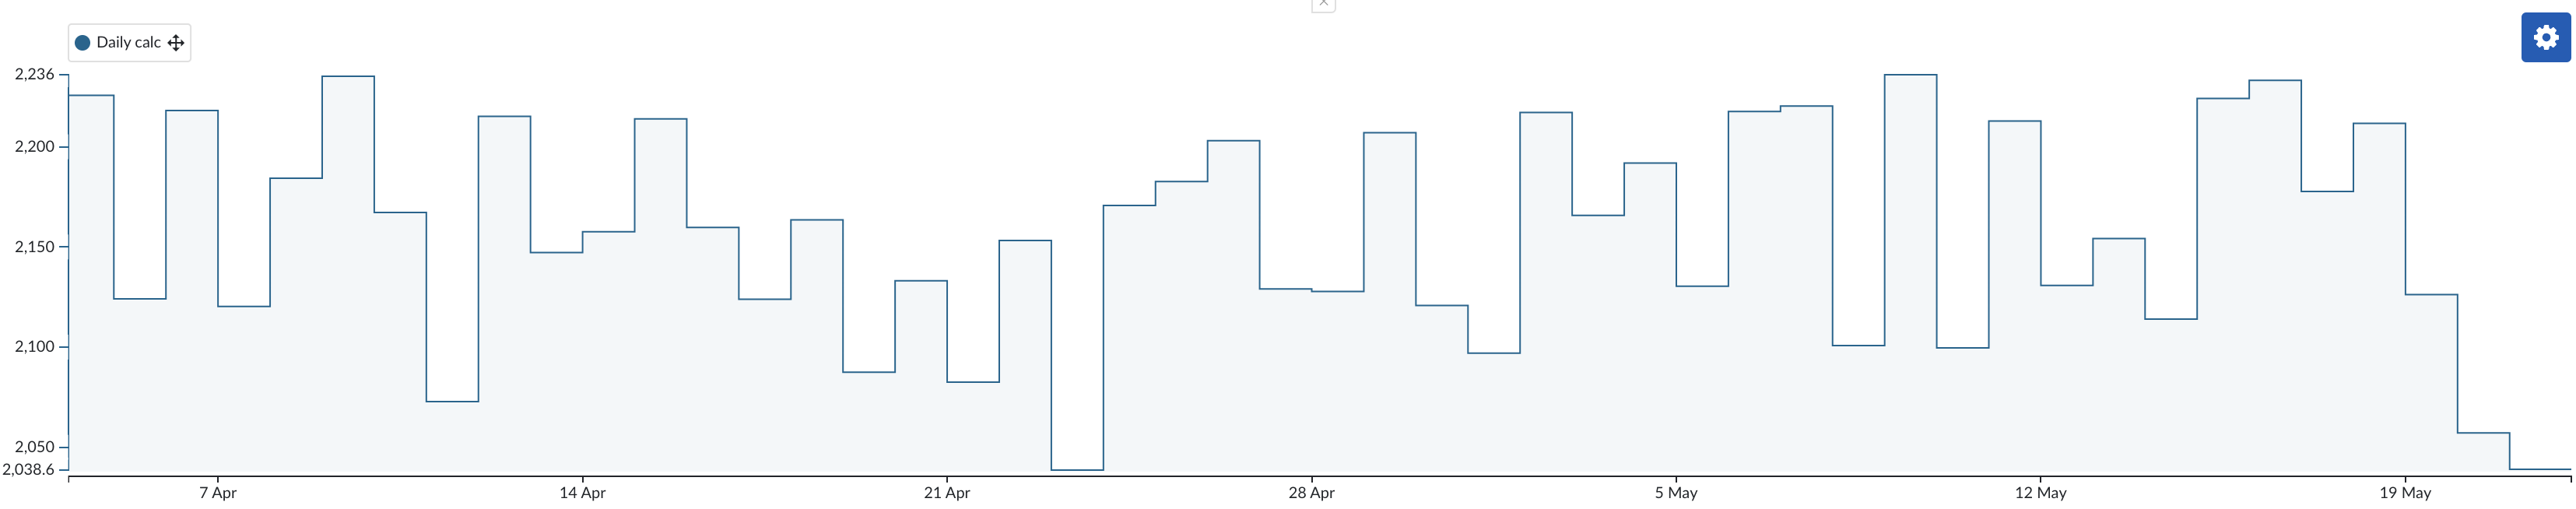

In [13]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# Frequency selection
# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# Daily: D | Weekly starting Monday: W-MON | Monthly: MS | Yearly: YS
freq = "D"  
maximal_duration = client.time.timedelta("25h")  # the maximal possible duration of one interval

# tag definition
tag1 = client.tag.get_by_name("[CS]BA:CONC.1")
tag2 = client.tag.get_by_name("[CS]BA:LEVEL.1")
tags = [tag1, tag2]


# calculation definition
def calculate(intervals):

    # Aggregations
    tag1.calculate(
        intervals=intervals,
        operation=TagCalculationOptions.MAXIMUM,
        key="calc1",
        inplace=True,
    )

    tag2.calculate(
        intervals=intervals,
        operation=TagCalculationOptions.MAXIMUM,
        key="calc2",
        inplace=True,
    )

    # Custom operations
    for interval in intervals:
        # Account for potential missing calculations
        try: 
            interval["result"] = interval["calc1"]*interval["calc2"]
        except KeyError:
            interval["result"] = None
        

# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)


# Determine the last point up to which we can perform calculations (all tags indexed)
check_interval = client.time.interval(
    index_interval.start,
    client.time.now(),
)

last_timestamp = min([
    tag.get_plot_data(check_interval, n_intervals=1).index[-1]
    for tag in tags
])

# Get intervals
intervals = client.time.interval.range(
    freq=freq,
    start=index_interval.start,
    end=min([
        index_interval.end + maximal_duration,
        last_timestamp,
    ]),
    normalize=True,
)

# Perform the calculation
calculate(intervals)

# Put the results in a Series
ser = pd.Series(
    index=[
        interval.start for interval in intervals 
    ],
    data=[
        interval["result"] for interval in intervals
    ],
)

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
if not ser.empty:
    ser.to_csv(
        os.environ["OUTPUT_FILE"]
    )

### Event count
This tag uses a value-based search to see how often the search criteria occur within a regular in. It only counts the search results that actually start in the interval. This tag type can be used to create monitorable summary statistics on a batch, campaign, or continuous run of equipment whose condition can be defined by a search.
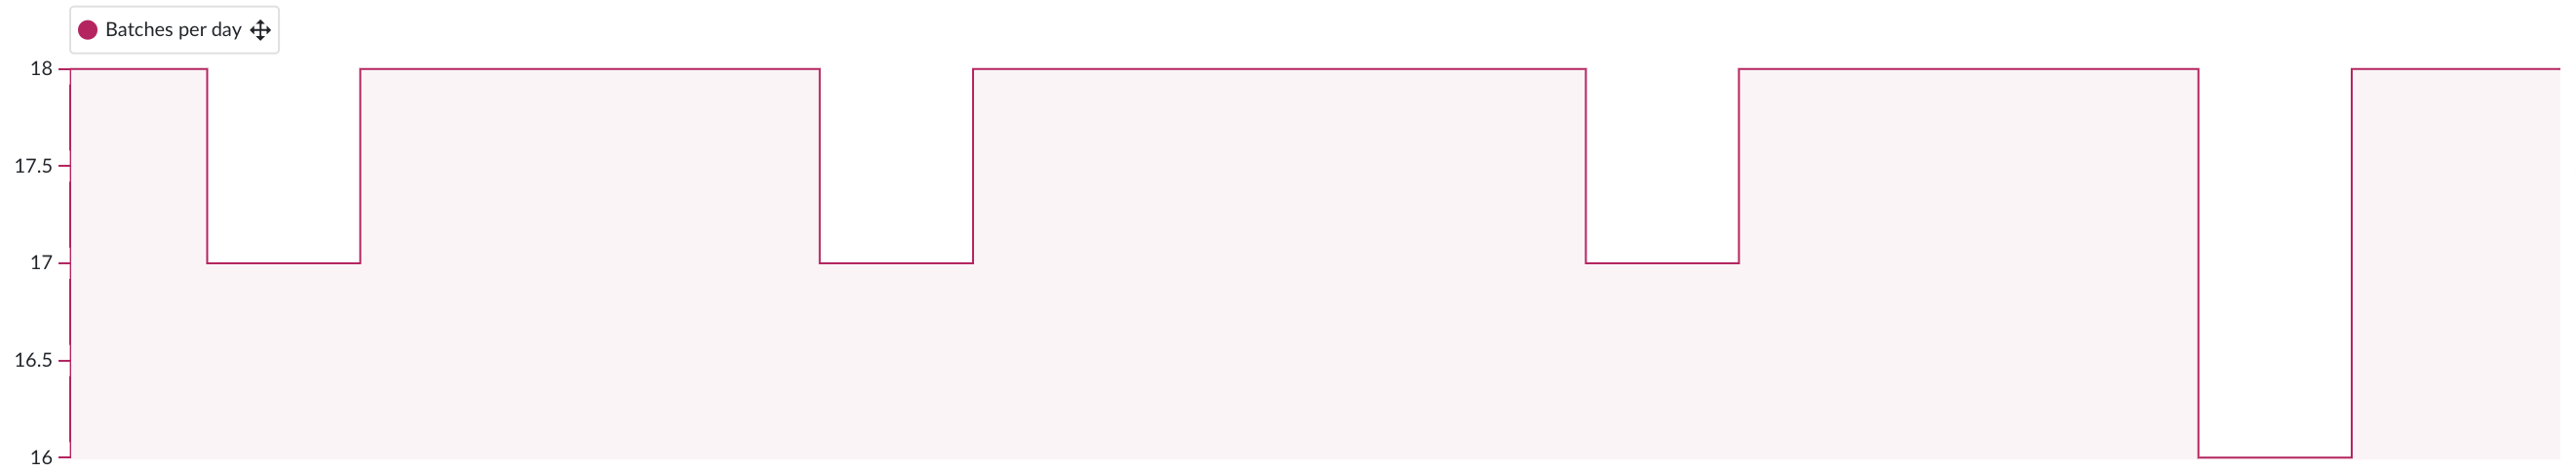

In [14]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# Frequency selection
# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# Daily: D | Weekly starting Monday: W-MON | Monthly: MS | Yearly: YS
freq = "D"  
maximal_duration = client.time.timedelta("25h")  # the maximal possible duration of one interval

# tag definition
tag1 = client.tag.get_by_name("[CS]BA:ACTIVE.1")
tags = [tag1]

# event search definition
search_duration = client.time.timedelta("2m")
event_search = client.search.value(
    queries=[
        (tag1, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
    duration=search_duration,
)
        
# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Determine the last point up to which we can perform calculations (all tags indexed)
check_interval = client.time.interval(
    index_interval.start,
    client.time.now(),
)

last_timestamp = min([
    tag.get_plot_data(check_interval, n_intervals=1).index[-1]
    for tag in tags
])

# Get regular intervals
intervals = client.time.interval.range(
    freq=freq,
    start=index_interval.start,
    end=min([
        index_interval.end + maximal_duration,
        last_timestamp - search_duration,
    ]),
    normalize=True,
)

# Get search results
search_interval = client.time.interval(
    index_interval.start - client.resolution,
    index_interval.end + maximal_duration,
)

results = event_search.get_results(search_interval)

# Count number of results that start in each regular interval
for interval in intervals:
    interval["count"] = sum([
        1 for result in results 
        if (interval.start <= result.start) 
        and (result.start < interval.end)
    ])

# Put the results in a Series
ser = pd.Series(
    index=[
        interval.start for interval in intervals 
    ],
    data=[
        interval["count"] for interval in intervals
    ],
)

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
if not ser.empty:
    ser.to_csv(
        os.environ["OUTPUT_FILE"]
    )

### Incrementing counter
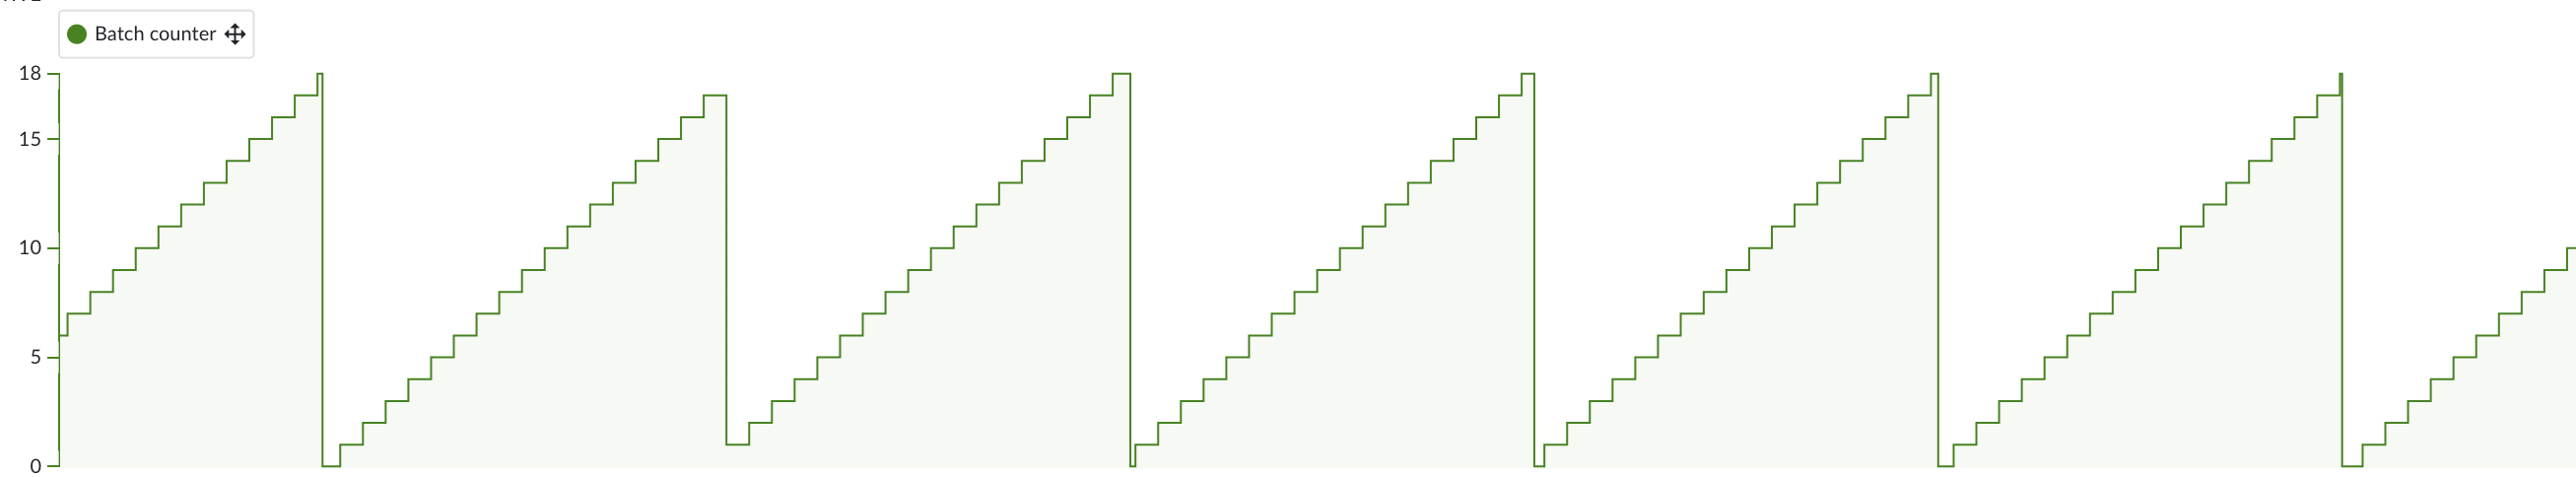

In [15]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# Frequency selection
# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# Daily: D | Weekly starting Monday: W-MON | Monthly: MS | Yearly: YS
freq = "D"  
maximal_duration = client.time.timedelta("25h")  # the maximal possible duration of one interval

# tag definition
tag1 = client.tag.get_by_name("[CS]BA:ACTIVE.1")
tags = [tag1]

# event search definition
search_duration = client.time.timedelta("2m")
event_search = client.search.value(
    queries=[
        (tag1, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
    duration=search_duration,
)
        
# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Determine the last point up to which we can perform calculations (all tags indexed)
check_interval = client.time.interval(
    index_interval.start,
    client.time.now(),
)

last_timestamp = min([
    tag.get_plot_data(check_interval, n_intervals=1).index[-1]
    for tag in tags
])

# Get regular intervals. In this case we also have to look backwards.
intervals = client.time.interval.range(
    freq=freq,
    start=index_interval.start - maximal_duration,
    end=index_interval.end + maximal_duration,
    normalize=True,
)

# Get search results
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

results = event_search.get_results(search_interval)

# Generate a dataframe per interval
ser_list = []
for interval in intervals:
    
    interval_results = [
        result for result in results 
        if (interval.start <= result.start) 
        and (result.start < interval.end)
    ]

    interval_ser = pd.Series(
        index=[result.start for result in interval_results],
        data=1,
    ).cumsum()

    # start at 0 unless first result starts at interval start
    if (len(interval_results) == 0) or (interval_results[0].start != interval.start):
        interval_ser = pd.concat(
            [
                pd.Series(
                    index=[interval.start],
                    data=[0],
                ),
                interval_ser,
            ]
        )
    
    ser_list.append(interval_ser)

# Concatenate the series
ser = pd.concat(ser_list)
ser.name = "value"
ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Incrementing totalizer
Incrementing integral

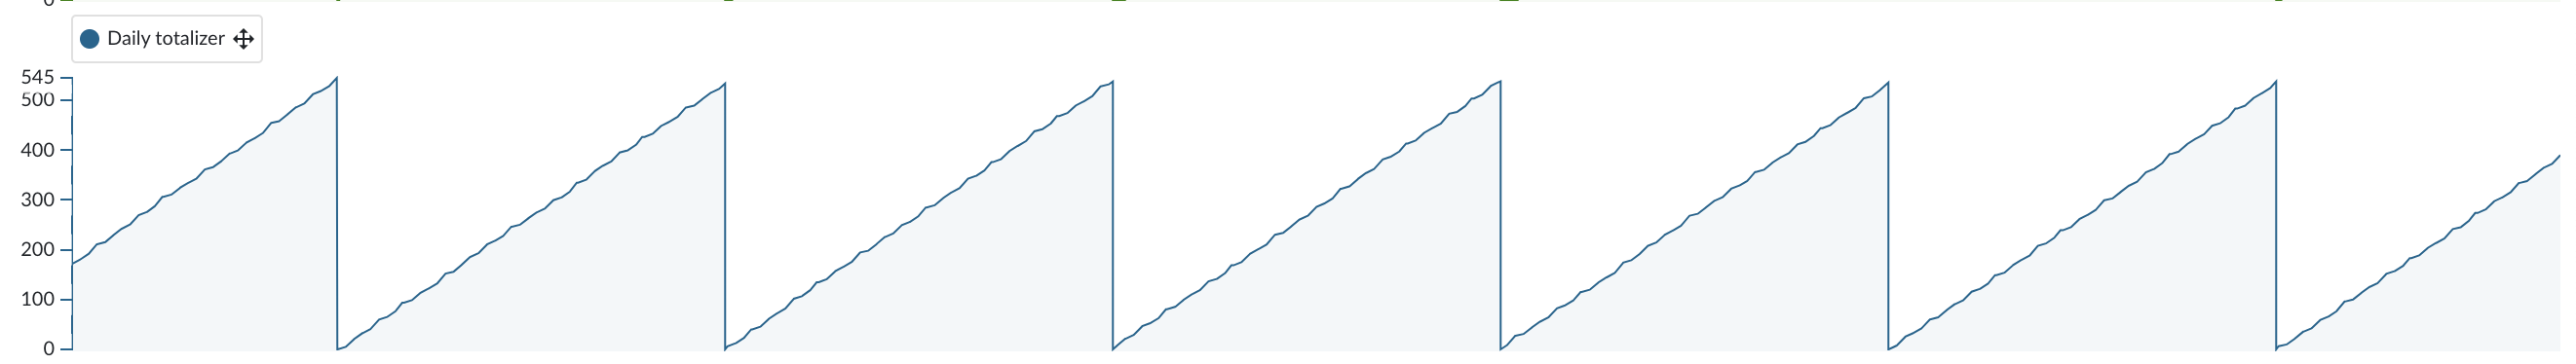

In [16]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.integrate import cumulative_trapezoid
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# Frequency selection
# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# Daily: D | Weekly starting Monday: W-MON | Monthly: MS | Yearly: YS
freq = "D"  
maximal_duration = client.time.timedelta("25h")  # the maximal possible duration of one interval

# tag definition; this is the tag we will integrate
tag_to_totalize = client.tag.get_by_name("[CS]BA:CONC.1")

# Time unit the tag is expressed in; required to get correct totalizer values
time_unit = client.time.timedelta("1h")  # here expressed in 'per hour'
        
# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Get regular intervals. In this case we also have to look backwards.
intervals = client.time.interval.range(
    freq=freq,
    start=index_interval.start - maximal_duration,
    end=index_interval.end + maximal_duration,
    normalize=True,
)

# Generate a dataframe per interval
ser_list = []
for interval in intervals:
    tag_data = tag_to_totalize.get_data(interval, resolution="1m")
    if len(tag_data) <=1:
        continue
    relative_index = tag_data.index - tag_data.index[0]
    x_coordinate = relative_index.total_seconds()/time_unit.total_seconds()
    total_values = cumulative_trapezoid(y=tag_data, x=x_coordinate)
    total_values = np.insert(total_values, 0, 0)  # start values at 0

    # Add 1ms to avoid duplicate timestamps
    totals = pd.Series(
        index=[tag_data.index[0] + timedelta(seconds=0.001)] + tag_data.index[1:].tolist(),
        data=total_values,
    )
    ser_list.append(totals)

# Concatenate the series
ser = pd.concat(ser_list)
ser.name = "value"
ser.index.name = "ts"


# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

## Tag templates for search results

These examples cover the operations that happen on search results. A search is first performed, and the results of the custom calculation are then plotted at the times of the search results.

In these templates, as an example we will simply search for the day being a Monday, Wednesday or Friday.

### Block aggregations using calculations on search results
Per search result, perform a custom calculation based on aggregations saved with the search.  This allows you to delve deeper into the evolution of search aggregate calculations and well as perform custom calculations (ex. KPIs or empirical formulae) on them.
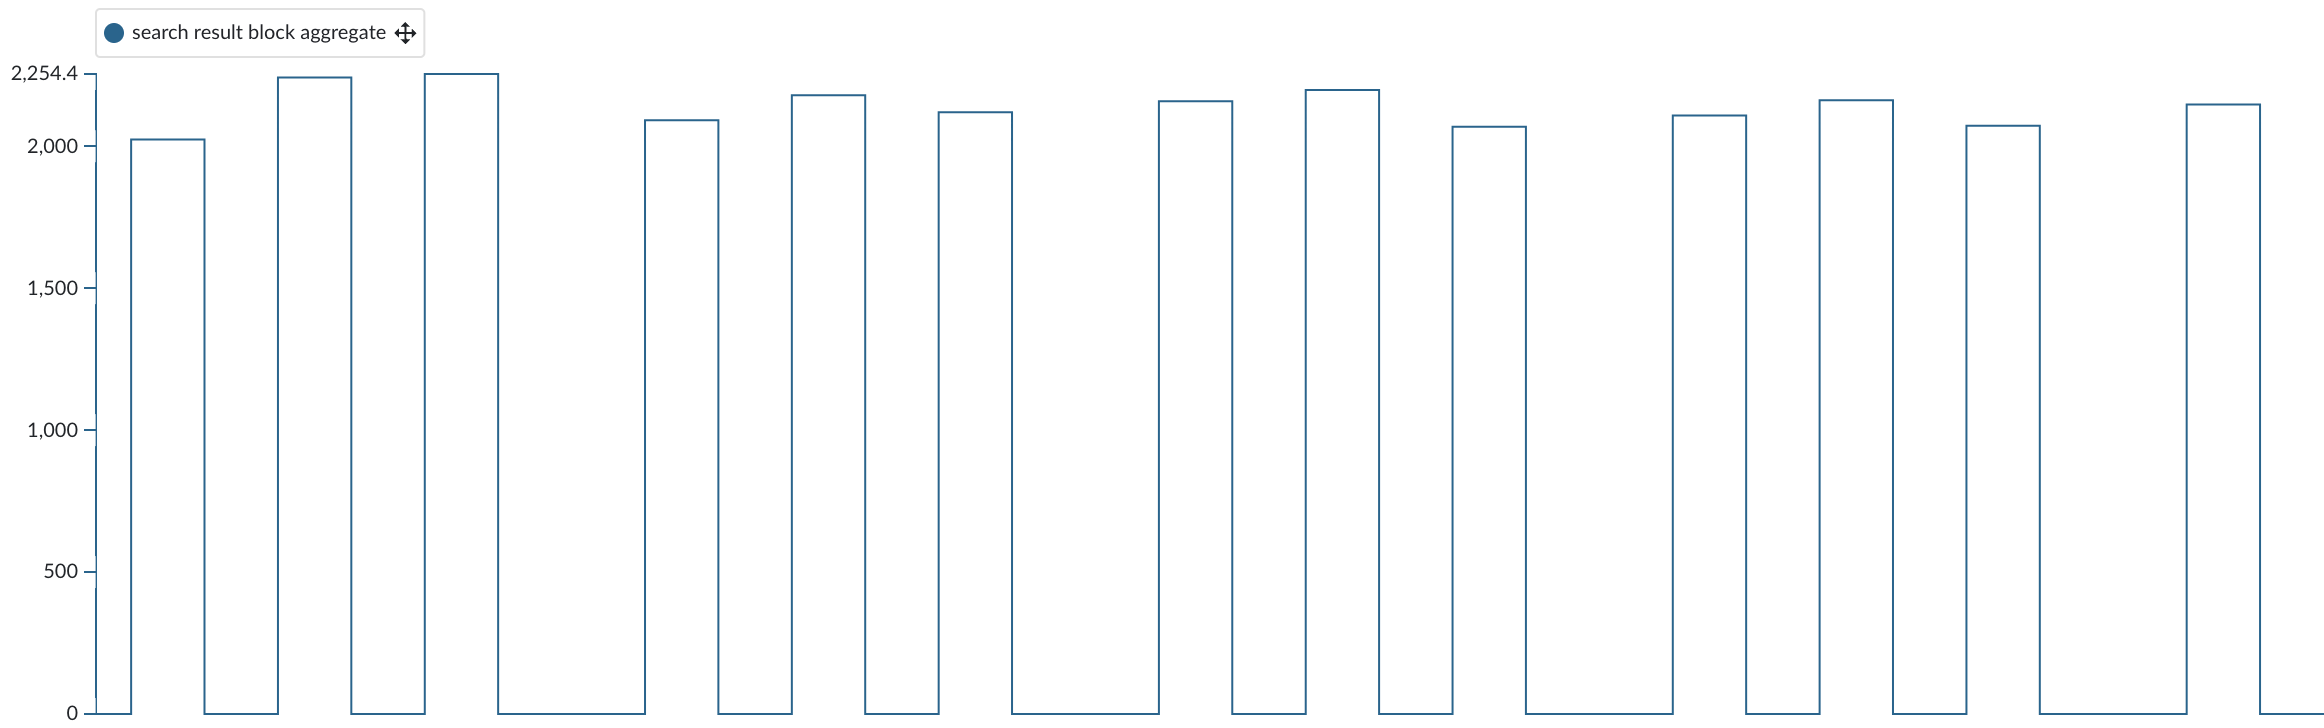

In [17]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions
from trendminer.sdk.search import ValueBasedSearchOperators, SearchCalculationOptions


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# default value to return to between results
default_value = 0

# tag definition; add these as dependencies!
tag1 = client.tag.get_by_name("[CS]BA:CONC.1")
tag2 = client.tag.get_by_name("[CS]BA:LEVEL.1")
tag3 = client.tag.get_by_name("TM_day_Europe_Brussels")

# search definition
search = client.search.value(
    queries=[
        (tag3, ValueBasedSearchOperators.IN_SET, ["Monday", "Wednesday", "Friday"])
    ],
    duration="23h",
    calculations={
        "calc1": (tag1, SearchCalculationOptions.MAXIMUM),
        "calc2": (tag2, SearchCalculationOptions.MAXIMUM),
    }
)

# maximal search result duration
maximal_duration = client.time.timedelta("25h")

# additional custom operation on search calculations
def calculate(intervals):
    for interval in intervals:
        # Account for potential missing calculations
        try:
            interval["result"] = interval["calc1"]*interval["calc2"]
        except KeyError:
            interval["result"] = None
        

# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Get results
intervals = search.get_results(search_interval)

# Remove open-ended result
if (len(intervals) > 0) and ((search_interval.end - intervals[-1].end) < client.resolution):
    intervals.pop(-1)

# Perform the calculation
calculate(intervals)

# Put the results in a Series
ser = pd.Series(
    name="value",
    index=[
        timestamp for interval in intervals 
        for timestamp in (interval.start, interval.end)
    ],
    data=[
        value for interval in intervals
        for value in (interval["result"], default_value)
    ],
)

ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Event count
Per search result, count the number of results of a second search that start within it.This algorithm can be applicable to counting events within a particular timeframe (such as tank filling periods during a campaign or equipment defouling within a particular maintenance interval) or that a particular step occurs within a batch.
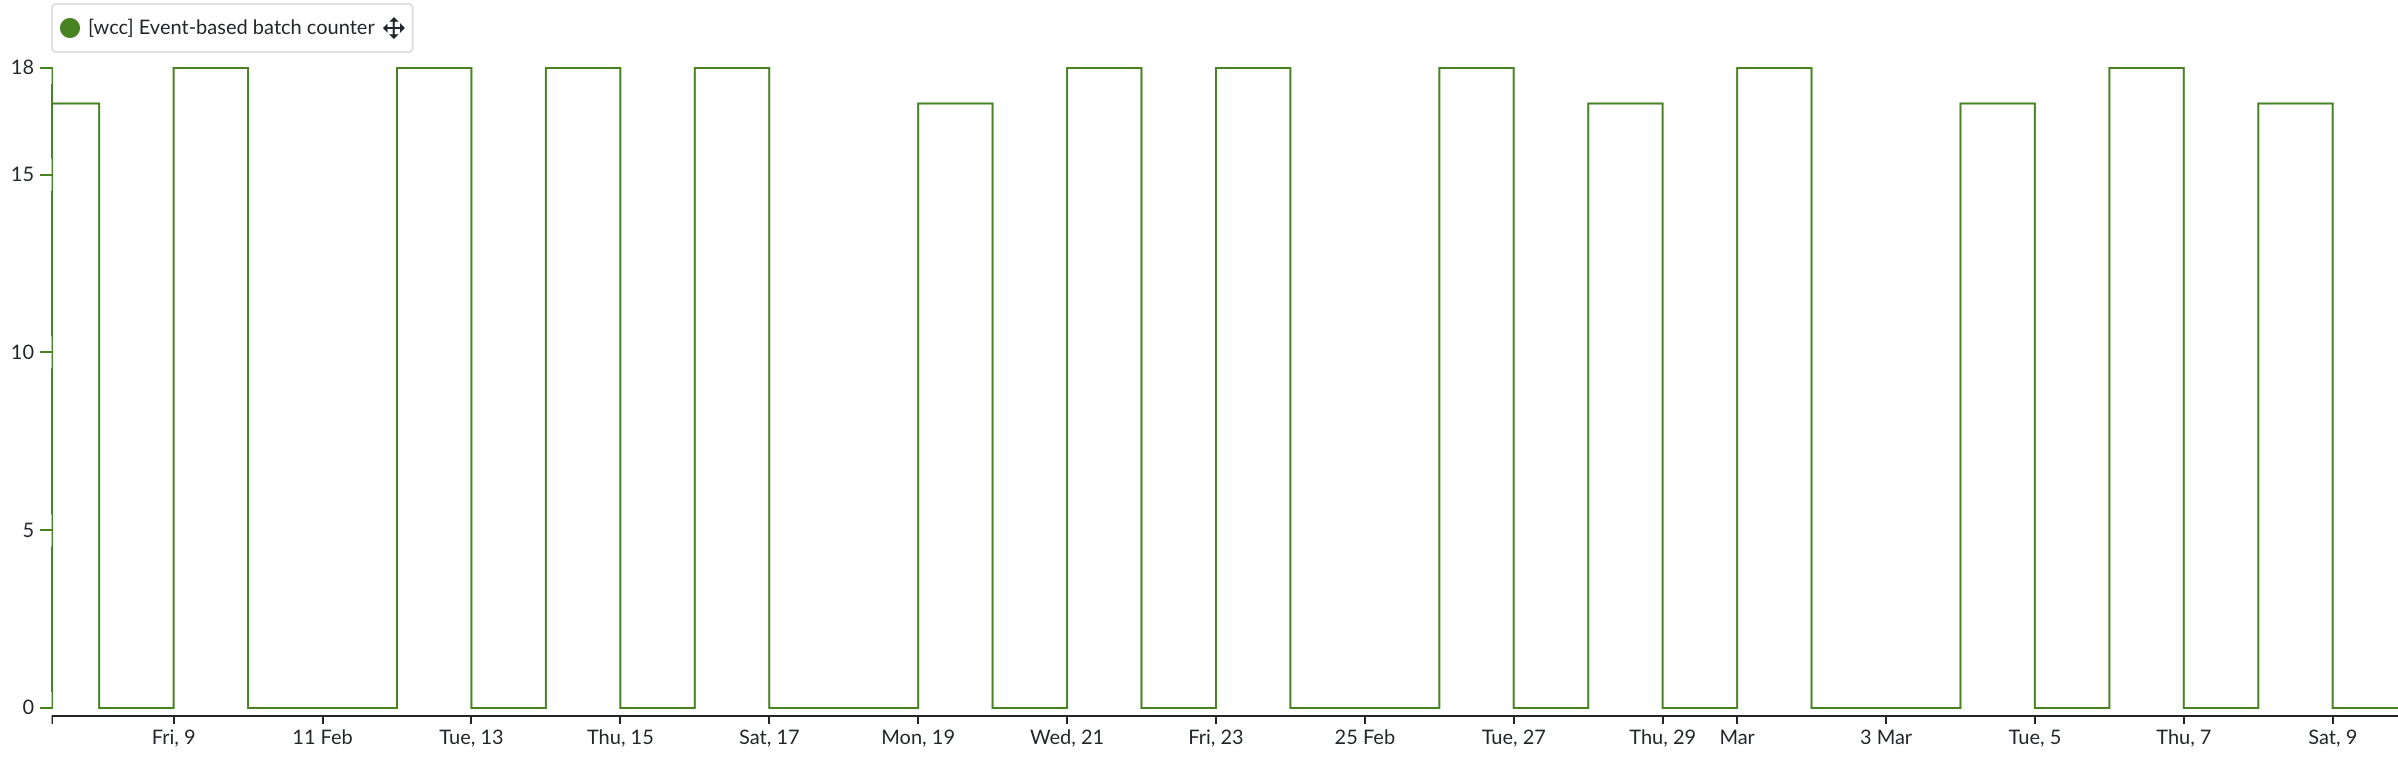

In [18]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.tag import TagCalculationOptions
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# default value to return to between results
default_value = 0

# tag definition; add these as dependencies!
tag1 = client.tag.get_by_name("TM_day_Europe_Brussels")
tag2 = client.tag.get_by_name("[CS]BA:ACTIVE.1")


# Base search definition
search = client.search.value(
    queries=[
        (tag1, ValueBasedSearchOperators.IN_SET, ["Monday", "Wednesday", "Friday"])
    ],
    duration="23h",
)

# event search definition
event_search_duration = client.time.timedelta("2m")
event_search = client.search.value(
    queries=[
        (tag2, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
    duration=event_search_duration,
)

# maximal search result duration over both searches
maximal_duration = client.time.timedelta("25h")

# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Get base search results
intervals = search.get_results(search_interval)

# Remove open-ended result
if (len(intervals) > 0) and ((search_interval.end - intervals[-1].end) < client.resolution):
    intervals.pop(-1)

# Get event restults
results = event_search.get_results(search_interval)

# Count number of results that start in each regular interval
for interval in intervals:
    interval["count"] = sum([
        1 for result in results 
        if (interval.start <= result.start) 
        and (result.start < interval.end)
    ])

# Put the results in a Series
ser = pd.Series(
    name="value",
    index=[
        timestamp for interval in intervals 
        for timestamp in (interval.start, interval.end)
    ],
    data=[
        value for interval in intervals
        for value in (interval["count"], default_value)
    ],
)

ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Incrementing event counter
Per main search result, have an incrementing counter for the results of a secondary search. This is similar to the last example’s application, but instead one single total count value, the counter starts at 0 and increments with 1 for every new result, resetting to 0 after the main search result concludes. This shows exactly when secondary results occured, and allows for more up to date indexing of the value rather than needing both search periods to conclude before calculating and indexing a value.
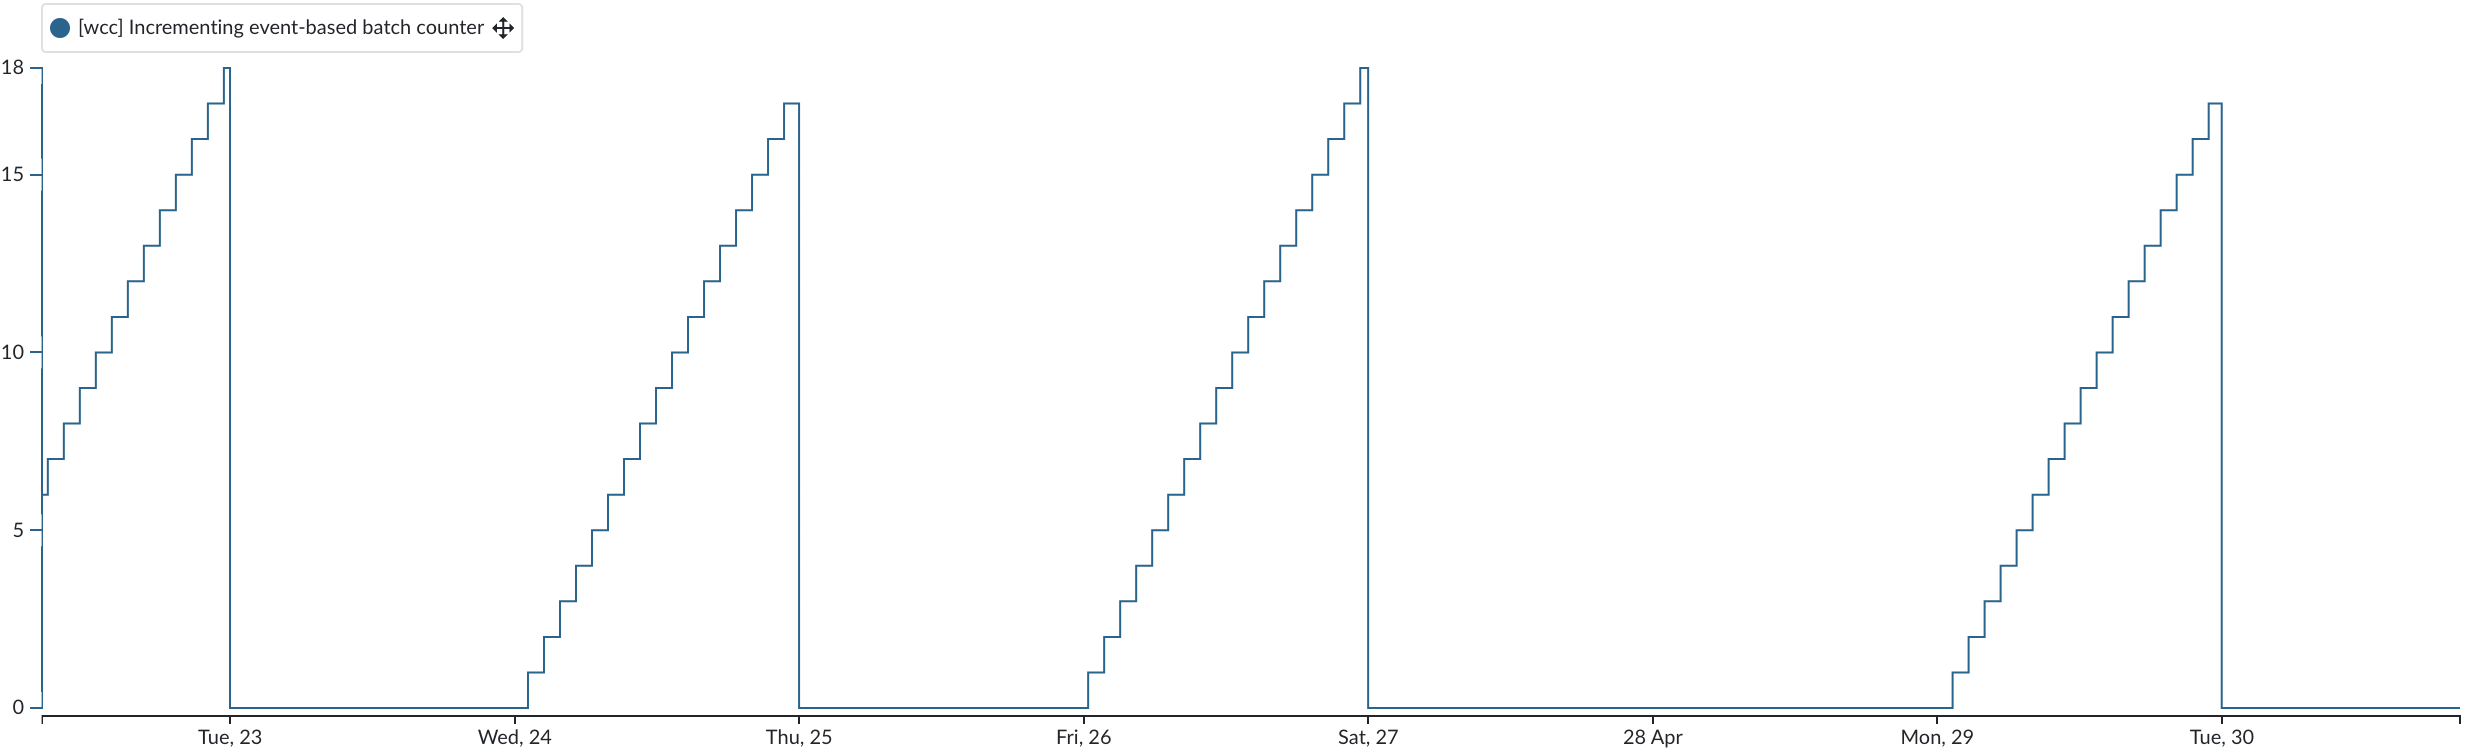

In [19]:
import os
import pandas as pd
from trendminer import TrendMinerClient
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# default value to return to between results
default_value = 0

# tag definition; add these as dependencies!
tag1 = client.tag.get_by_name("TM_day_Europe_Brussels")
tag2 = client.tag.get_by_name("[CS]BA:ACTIVE.1")


# Base search definition
search = client.search.value(
    queries=[
        (tag1, ValueBasedSearchOperators.IN_SET, ["Monday", "Wednesday", "Friday"])
    ],
    duration="23h",
)

# event search definition
event_search_duration = client.time.timedelta("2m")
event_search = client.search.value(
    queries=[
        (tag2, ValueBasedSearchOperators.IN_SET, ["Active"])
    ],
    duration=event_search_duration,
)

# maximal search result duration over both searches
maximal_duration = client.time.timedelta("25h")

# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Get base search results
intervals = search.get_results(search_interval)

# Remove open-ended result
if (len(intervals) > 0) and ((search_interval.end - intervals[-1].end) < client.resolution):
    intervals.pop(-1)

# Get event restults
results = event_search.get_results(search_interval)

# Generate a dataframe per base search result
ser_list = []
for interval in intervals:
    
    interval_results = [
        result for result in results 
        if (interval.start <= result.start) 
        and (result.start < interval.end)
    ]

    interval_ser = pd.Series(
        index=[result.start for result in interval_results],
        data=1,
    ).cumsum()

    # start at 0 unless first result starts at interval start
    if (len(interval_results) == 0) or (interval_results[0].start != interval.start):
        interval_ser = pd.concat(
            [
                pd.Series(
                    index=[interval.start],
                    data=[0],
                ),
                interval_ser,
            ]
        )

    # Reset to default value after the event
    interval_ser = pd.concat(
        [
            interval_ser,
            pd.Series(
                index=[interval.end],
                data=[default_value],
            )
        ]
    )
    
    ser_list.append(interval_ser)

# Concatenate the series
ser = pd.concat(ser_list)
ser.name = "value"
ser.index.name = "ts"

# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)

### Incrementing value totalizer
Totalize a given tag over the course of a search result. Typically, we do not want to wait until search results are completed, or add a minimal duration to the search, as that would delay the totalizer. This tag type shows the evolution of the same event summary variables that can be obtained by calculations on search results, allowing for monitoring and proactive response to deviation from expected values.
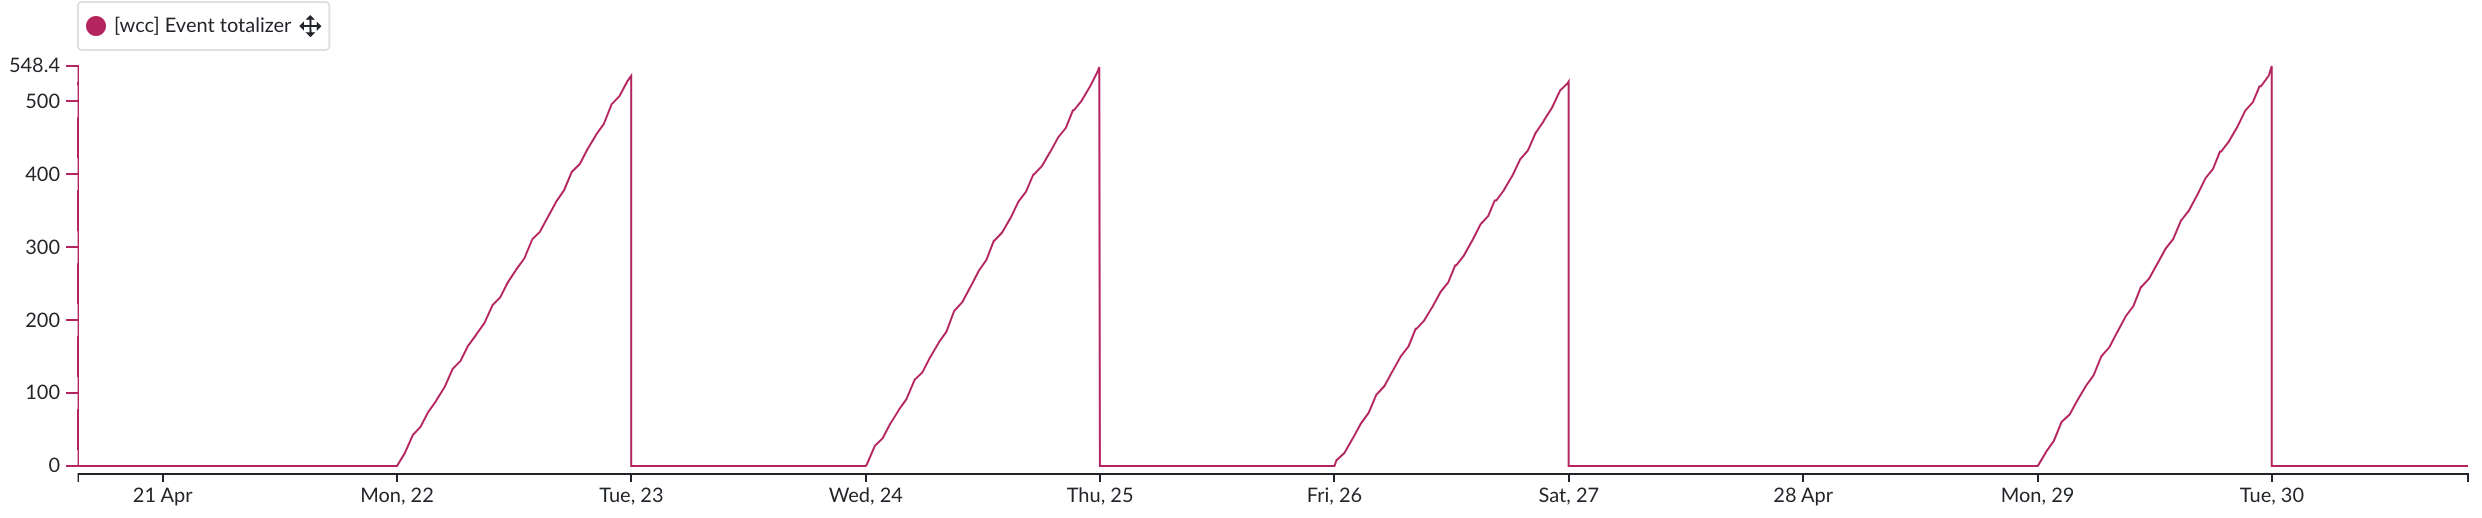

In [20]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.integrate import cumulative_trapezoid
from trendminer import TrendMinerClient
from trendminer.sdk.search import ValueBasedSearchOperators


# ---- PARAMETERS -----

# Initialize client
client = TrendMinerClient.from_token(
    token=os.environ["ACCESS_TOKEN"],
    tz="Europe/Brussels",  # <--- SET TIMEZONE
)

# default value to return to between results
default_value = 0

# tag definition; add these as dependencies!
tag1 = client.tag.get_by_name("TM_day_Europe_Brussels")

tag_to_totalize= client.tag.get_by_name("[CS]BA:CONC.1")

# Time unit the tag is expressed in; required to get correct totalizer values
time_unit = client.time.timedelta("1h")  # here expressed in 'per hour'

# Base search definition
search = client.search.value(
    queries=[
        (tag1, ValueBasedSearchOperators.IN_SET, ["Monday", "Wednesday", "Friday"])
    ],
    duration="2m",
)

# maximal search result duration
maximal_duration = client.time.timedelta("25h")

# ---- CODE EXECUTION -----

# Received index interval
index_interval = client.time.interval(
    os.environ["START_TIMESTAMP"], 
    os.environ["END_TIMESTAMP"],
)

# Widen interval
search_interval = client.time.interval(
    index_interval.start - maximal_duration,
    index_interval.end + maximal_duration,
)

# Get search results
intervals = search.get_results(search_interval)

# Generate a dataframe per interval
ser_list = []
for interval in intervals:
    tag_data = tag_to_totalize.get_data(interval, resolution="1m")
    if len(tag_data) <= 1:
        continue
    relative_index = tag_data.index - tag_data.index[0]
    x_coordinate = relative_index.total_seconds()/time_unit.total_seconds()
    total_values = cumulative_trapezoid(y=tag_data, x=x_coordinate)
    total_values = np.insert(total_values, 0, 0)  # start values at 0

    # Add 1ms to avoid duplicate timestamps
    totals = pd.Series(
        index=[tag_data.index[0] + timedelta(seconds=0.001)] + tag_data.index[1:].tolist(),
        data=total_values,
    )

    # Return to default value in between search results; only for completed results
    if (default_value is not None) and (interval.end < index_interval.end):
        totals = pd.concat(
            [
                totals,
                pd.Series(index=[interval.end+timedelta(seconds=0.001)], data=[default_value])
            ]
        )
    
    ser_list.append(totals)

# Concatenate the series
ser = pd.concat(ser_list)
ser.name = "value"
ser.index.name = "ts"


# Filter for timestamps and NaN values
ser = (
    ser
    .loc[lambda x: x.index > index_interval.start]
    .loc[lambda x: x.index <= index_interval.end]
    .dropna()
)

# To file
ser.to_csv(
    os.environ["OUTPUT_FILE"]
)